## Winning in the Data Science Field

For this project I have chosen to use the 2019 Kaggle ML & DS Survey.

In [479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
%matplotlib inline
#sns.set(style="white")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

# Import data
df = pd.read_csv('./multiple_choice_responses.csv')

## Data Cleaning Steps

In [480]:
# Filter data among professionals only
df = df[~df.Q5.isin(['Student', 'Not employed']) & df.Q5.notnull()]

# Filter data among residents of the US only
df = df[df.Q3.isin(['United States of America'])]

# Filter data among annual salary of >10K
df = df[~df.Q5.isin(['$0-999','1,000-1,999','2,000-2,999','3,000-3,999','4,000-4,999','5,000-7,499','7,500-9,999']) & df.Q5.notnull()]

# Recode some of the salary bins
df.loc[df['Q10'].isin(['10,000-14,999','15,000-19,999']), 'Q10'] = '10,000-19,999'
df.loc[df['Q10'].isin(['20,000-24,999','25,000-29,999']), 'Q10'] = '20,000-29,999'
df.loc[df['Q10'].isin(['300,000-500,000','> $500,000']), 'Q10'] = '>= $300,000'

## Function Creation

In [607]:
##### Function to create barplots for questions that are categorical and single answer
def barplots_single_answer(q_number, x_title, y_title, chart_title, order=None):
    cat_values = round((df[pd.notnull(df[q_number])][q_number].value_counts()/len(df[pd.notnull(df[q_number])][q_number])) * 100,1)
    cat_values = cat_values.reset_index().rename(columns = {'index':q_number, q_number:'pct'}) 
    f, ax = plt.subplots(figsize=(8,8))
    sns.barplot(x = 'pct', y = q_number, data=cat_values, color='dodgerblue', order=order)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.title(chart_title, fontsize = 14, fontweight ='bold')

def barplots_heatmap_single_answer(q_number, bar_chart_title, heatmap_title, order_rows = False):
    '''
    INPUT:
    q_number - question number for the variable of interest. It should be a single-answer question.
    chart_title - what you want for the main title
    order_rows - desired sorting of the rows (will default to descending according to frequency of answers)

    OUTPUT:
    Two charts: A barplot that shows the frequency in % for the variable of interest, and a heatmap
    that visually correlates the variable of interest with salary range.
    
    This function prepares the data for the visualization and provides the two visualizations specified.
    '''        
    # Value count for the variable of interest
    cat_values = df[pd.notnull(df[q_number])][q_number].value_counts()
    # Set a threshold of 20 records for category to be included in plotting, otherwise it will distort the normalized heatmap 
    cat_values = cat_values[cat_values>=20]
    cat_values = round((cat_values/len(df[pd.notnull(df[q_number])][q_number])) * 100,1)
    if(order_rows == False):
        cat_values = cat_values
    else:
        cat_values = cat_values.reindex(index = order_rows) 
    cat_values = cat_values.reset_index().rename(columns = {'index':q_number, q_number:'pct'}) 

    # Sort order for the salary bins
    order_col = ['10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
                 '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999',
                 '150,000-199,999','200,000-249,999', '250,000-299,999','>= $300,000']
    y_labels = cat_values[q_number]
        
    # Crosstabs for the salary and variable of interest
    crosstab = pd.crosstab(df[q_number],df['Q10'], normalize='index')
    crosstab = crosstab.reindex(order_col, axis="columns")    
    if(order_rows == False):
        crosstab = crosstab.reindex(y_labels, axis="rows")
    else:
        crosstab = crosstab.reindex(order_rows, axis="rows")        

    # Set-up subplots
    fig = plt.figure(figsize=(14,6))
    grid = plt.GridSpec(1, 10, wspace=10, hspace=1)
    plt.subplot(grid[0, :3])
    
    # Left plot (barplot)
    ax1 = sns.barplot(x = 'pct', y = q_number, data=cat_values, color='dodgerblue', order=None)
    plt.title(bar_chart_title, fontsize = 14, fontweight ='bold')
    ax1.set_xlabel('Percentage %')
    ax1.set_ylabel('')    
    # Text-wrapping of y-labels
    f = lambda x: textwrap.fill(x.get_text(), 27)
    ax1.set_yticklabels(map(f, ax1.get_yticklabels()))
    
    # Right plot (heatmap)
    plt.subplot(grid[0, 4:])
    ax2 = sns.heatmap(crosstab, cmap="Blues", cbar=False)
    plt.title(heatmap_title, fontsize = 14, fontweight ='bold')
    ax2.set_xlabel('Yearly Salary')
    ax2.set_ylabel('')
    ax2.set_yticklabels(map(f, ax2.get_yticklabels()))
    
    print(cat_values)

def barplots_heatmap_multi_answer(multi_question_list, bar_chart_title, heatmap_title, order_rows = False):
    '''
    INPUT:
    q_number - question number for the variable of interest. It should be a single-answer question.
    chart_title - what you want for the main title
    order_rows - desired sorting of the rows (will default to descending according to frequency of answers)

    OUTPUT:
    Two charts: A barplot that shows the frequency in % for the variable of interest, and a heatmap
    that visually correlates the variable of interest with salary range.
    
    This function prepares the data for the visualization and provides the two visualizations specified.
    '''        
    multi_question = multi_question_list

    df_store = []
    
    for question in (multi_question):
        df_temp = df[question].value_counts()
        df_store.append(df_temp)
    df_multi = pd.concat(df_store)
    df_multi = pd.DataFrame(df_multi).reset_index().rename(columns = {'index':multi_question[0], 0:'pct'}) 
    df_multi = df_multi[df_multi['pct']>=20]
    df_multi['pct'] = round(df_multi['pct']/sum(df_multi['pct']) * 100,1)
    if(order_rows == False):
        df_multi = df_multi.sort_values('pct', ascending=False)
    else:
        df_multi = df_multi.reindex(index = order_rows) 
 
    # Sort order for the salary bins
    order_col = ['10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
                 '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999',
                 '150,000-199,999','200,000-249,999', '250,000-299,999','>= $300,000']
    y_labels = df_multi[multi_question[0]]

    # Crosstabs for the salary and variable of interest
    df_store_xtab = []
    for question in (multi_question):
        df_temp_xtab = pd.crosstab(df[question],df['Q10'], normalize='index')
        df_store_xtab.append(df_temp_xtab)
    df_multi_xtab = pd.concat(df_store_xtab)    
    
    df_multi_xtab = df_multi_xtab.reindex(order_col, axis="columns")    
    
    if(order_rows == False):
        df_multi_xtab = df_multi_xtab.reindex(y_labels, axis="rows")
    else:
        df_multi_xtab = df_multi_xtab.reindex(order_rows, axis="rows")        

    # Set-up subplots
    fig = plt.figure(figsize=(14,6))
    grid = plt.GridSpec(1, 10, wspace=10, hspace=1)
    plt.subplot(grid[0, :3])
    
    # Left plot (barplot)
    ax1 = sns.barplot(x = 'pct', y = multi_question[0], data=df_multi, color='dodgerblue', order=None)
    plt.title(bar_chart_title, fontsize = 14, fontweight ='bold')
    ax1.set_xlabel('Percentage %')
    ax1.set_ylabel('')    
    # Text-wrapping of y-labels
    f = lambda x: textwrap.fill(x.get_text(), 27)
    ax1.set_yticklabels(map(f, ax1.get_yticklabels()))
    
    # Right plot (heatmap)
    plt.subplot(grid[0, 4:])
    ax2 = sns.heatmap(df_multi_xtab, cmap="Blues", cbar=False)
    plt.title(heatmap_title, fontsize = 14, fontweight ='bold')
    ax2.set_xlabel('Yearly Salary')
    ax2.set_ylabel('')
    ax2.set_yticklabels(map(f, ax2.get_yticklabels()))
    
    print(df_multi)    

In [590]:
multi_question = ['Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3', 'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 'Q18_Part_8',
                 'Q18_Part_9', 'Q18_Part_10', 'Q18_Part_11', 'Q18_Part_12']

df_store = []
for question in (multi_question):
    df_temp = df[question].value_counts()
    df_store.append(df_temp)

df_multi = pd.concat(df_store)

df_multi = pd.DataFrame(df_multi).reset_index().rename(columns = {'index':multi_question[0], 0:'pct'}) 

df_multi = df_multi[df_multi['pct']>=20]
df_multi['pct'] = round(df_multi['pct']/sum(df_multi['pct']) * 100,1)
#if(order_rows == False):
#    df_multi = df_multi.sort_values('pct', ascending=False)
#else:
#    df_multi = df_multi.reindex(index = order_rows) 

print(df_multi)

    Q18_Part_1   pct
0       Python  30.3
1            R  15.2
2          SQL  21.9
3            C   2.2
4          C++   3.7
5         Java   3.9
6   Javascript   5.5
7   TypeScript   1.1
8         Bash   8.4
9       MATLAB   2.8
11       Other   5.0


In [605]:
multi_question = ['Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3', 'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 'Q18_Part_8',
                 'Q18_Part_9', 'Q18_Part_10', 'Q18_Part_11', 'Q18_Part_12']
# Sort order for the salary bins
order_col = ['10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
             '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999',
             '150,000-199,999','200,000-249,999', '250,000-299,999','>= $300,000']
y_labels = df_multi[multi_question[0]]

# Crosstabs for the salary and variable of interest
df_store_xtab = []
for question in (multi_question):
    df_temp_xtab = pd.crosstab(df[question],df['Q10'], normalize='index')
    df_store_xtab.append(df_temp_xtab)
df_multi_xtab = pd.concat(df_store_xtab)

## A. Who are the data practitioners and how do they practice data science?

### 1. Data Practitioners Distribution (Q5) - Bar Chart

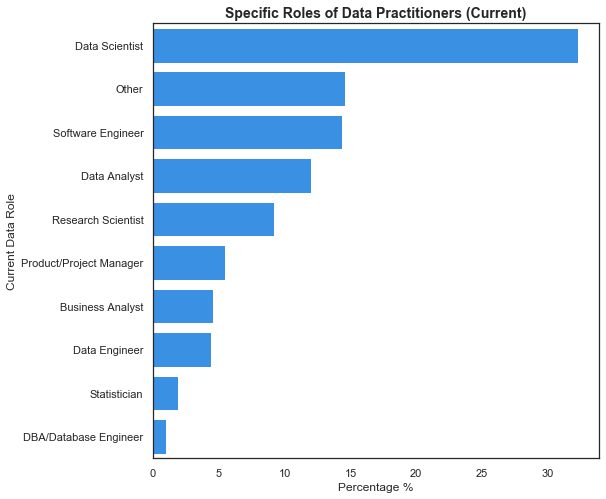

In [513]:
barplots_single_answer('Q5', 'Percentage %', 'Current Data Role', 'Specific Roles of Data Practitioners (Current)')

### 2. Salary Distribution (Q10) - Bar Chart

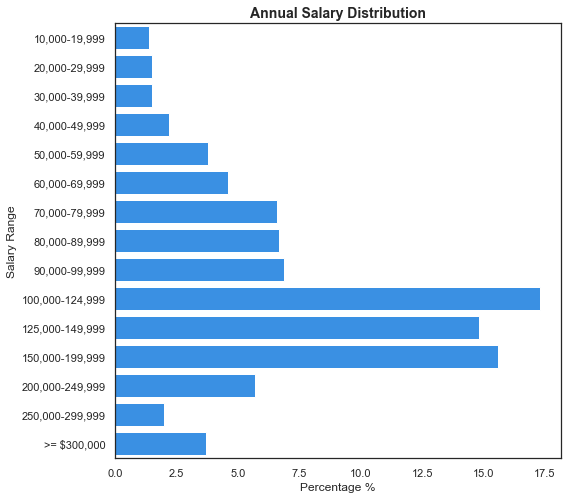

In [515]:
barplots_single_answer('Q10', 'Percentage %', 'Salary Range', 'Annual Salary Distribution',
               ['10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
                 '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999',
                 '150,000-199,999','200,000-249,999', '250,000-299,999','>= $300,000'])

### 3. Salary Distribution by Data Practitioner Type - Heatmap 

Text(0.5, 1, 'Annual Salary by Data Science Role')

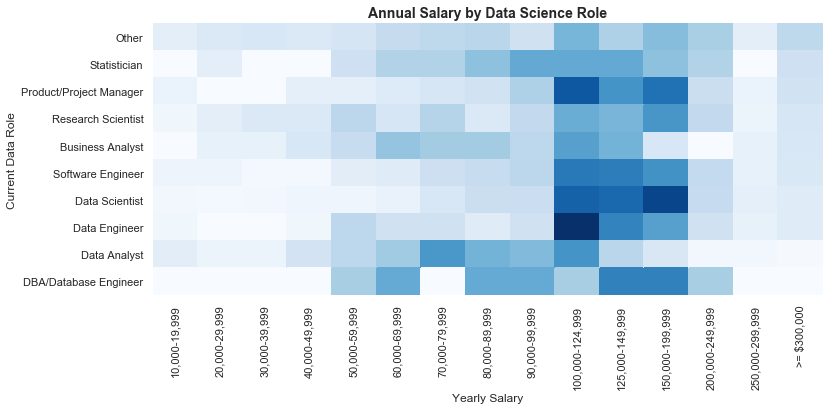

In [516]:
order_col = ['10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
                 '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999',
                 '150,000-199,999','200,000-249,999', '250,000-299,999','>= $300,000']

crosstab_dataprac = pd.crosstab(df['Q5'],df['Q10'], normalize='index')
crosstab_dataprac = crosstab_dataprac.reindex(order_col, axis="columns")
crosstab_dataprac = crosstab_dataprac.sort_values(crosstab_dataprac.columns[14], ascending=False)

f, ax = plt.subplots(figsize=(12,5))

ax = sns.heatmap(crosstab_dataprac, cmap="Blues", cbar=False)
ax.set_xlabel('Yearly Salary')
ax.set_ylabel('Current Data Role')
plt.title("Annual Salary by Data Science Role", fontsize = 14, fontweight ='bold')

### 4.a Primary Data Analysis Tools 

                                                                    Q14   pct
0            Local development environments (RStudio, JupyterLab, etc.)  51.0
1     Basic statistical software (Microsoft Excel, Google Sheets, etc.)  12.8
2              Cloud-based data software & APIs (AWS, GCP, Azure, etc.)  12.1
3  Business intelligence software (Salesforce, Tableau, Spotfire, etc.)   9.0
4                       Advanced statistical software (SPSS, SAS, etc.)   8.0
5                                                                 Other   7.2


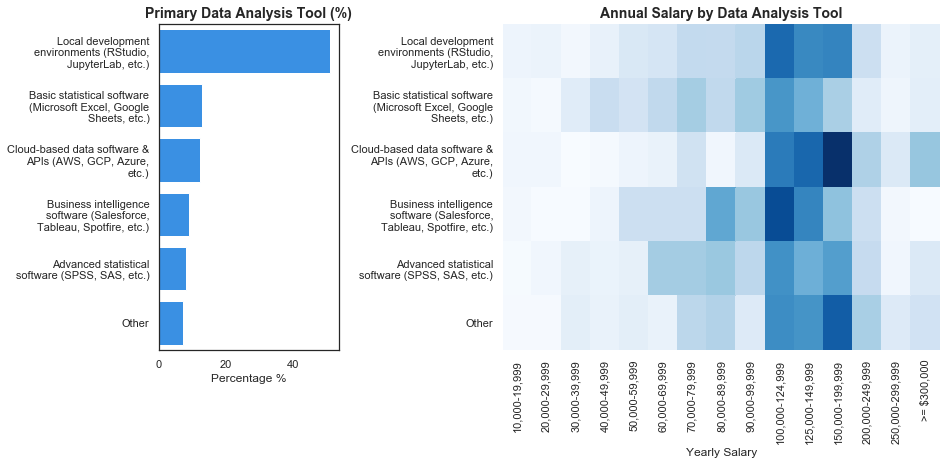

In [608]:
barplots_heatmap_single_answer('Q14', 'Primary Data Analysis Tool (%)', 'Annual Salary by Data Analysis Tool')

### 4.b Programming Languages Used 

    Q18_Part_1   pct
0       Python  30.3
2          SQL  21.9
1            R  15.2
8         Bash   8.4
6   Javascript   5.5
11       Other   5.0
5         Java   3.9
4          C++   3.7
9       MATLAB   2.8
3            C   2.2
7   TypeScript   1.1


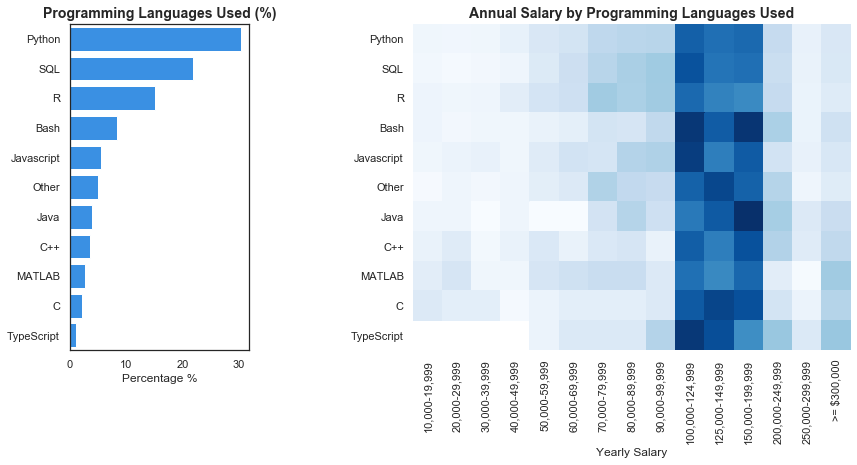

In [613]:
barplots_heatmap_multi_answer(['Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3', 'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 'Q18_Part_8',
                 'Q18_Part_9', 'Q18_Part_10', 'Q18_Part_11', 'Q18_Part_12'], 
                              'Programming Languages Used (%)', 
                              'Annual Salary by Programming Languages Used', 
                              order_rows = False)

### 4.c Number of Programming Languages Used (Derive) 

### 4.d Other technologies  (Choose top 10)

## B. How did they learn the practice?

### 6. Highest level of educational attainment (Q4) - Bar chart and salary heatmap side by side

                                                                  Q4   pct
0                                                    Doctoral degree  22.0
1                                                    Master’s degree  50.0
2                                                Professional degree   1.2
3                                                  Bachelor’s degree  22.5
4  Some college/university study without earning a bachelor’s degree   3.5


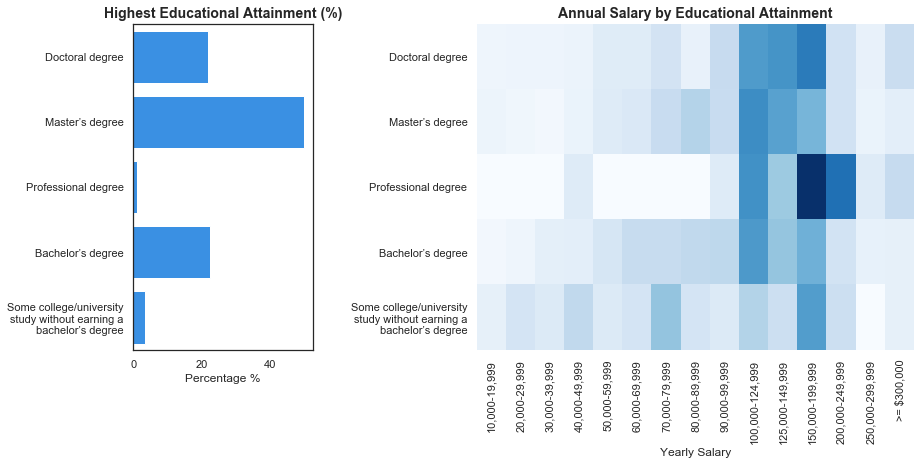

In [610]:
barplots_heatmap_single_answer('Q4', 'Highest Educational Attainment (%)', 'Annual Salary by Educational Attainment',
                               order_rows=['Doctoral degree', 'Master’s degree', 'Professional degree', 'Bachelor’s degree',
                                           'Some college/university study without earning a bachelor’s degree'])

### 7. Platforms where learn data science (Q13) - Bar chart and salary heatmap side by side

                                               Q13_Part_1   pct
1                                                Coursera  22.2
9   University Courses (resulting in a university degree)  12.1
3                                                DataCamp  10.6
7                                                   Udemy  10.5
5                      Kaggle Courses (i.e. Kaggle Learn)  10.4
0                                                 Udacity   8.9
2                                                     edX   8.4
6                                                 Fast.ai   4.5
8                                       LinkedIn Learning   4.4
10                                                   None   3.5
11                                                  Other   2.8
4                                               DataQuest   1.7


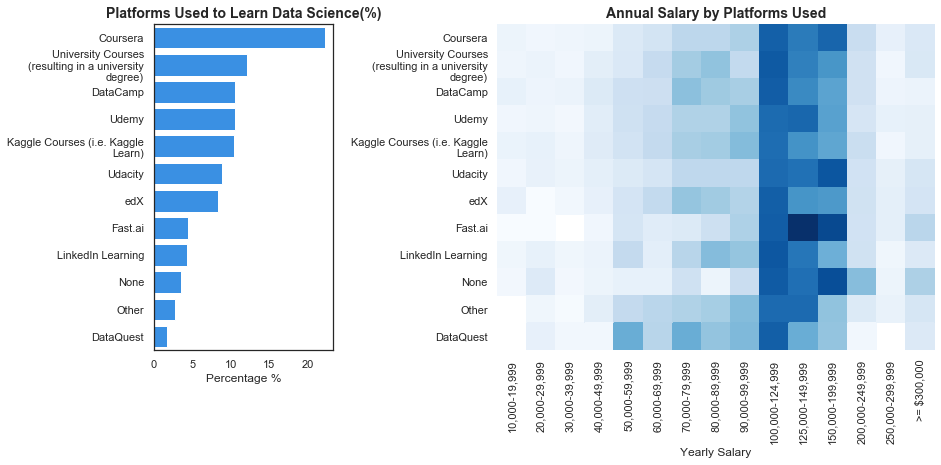

In [614]:
barplots_heatmap_multi_answer(['Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_5', 'Q13_Part_6', 
                               'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q13_Part_10', 'Q13_Part_11', 'Q13_Part_12'], 
                              'Platforms Used to Learn Data Science(%)', 
                              'Annual Salary by Platforms Used', 
                              order_rows = False)

### 8. How long have been doing code to analyze data (Q15) - Bar chart and salary heatmap side by side

                         Q15   pct
0  I have never written code   2.7
1                  < 1 years   7.1
2                  1-2 years  15.4
3                  3-5 years  25.8
4                 5-10 years  22.0
5                10-20 years  15.6
6                  20+ years  11.5


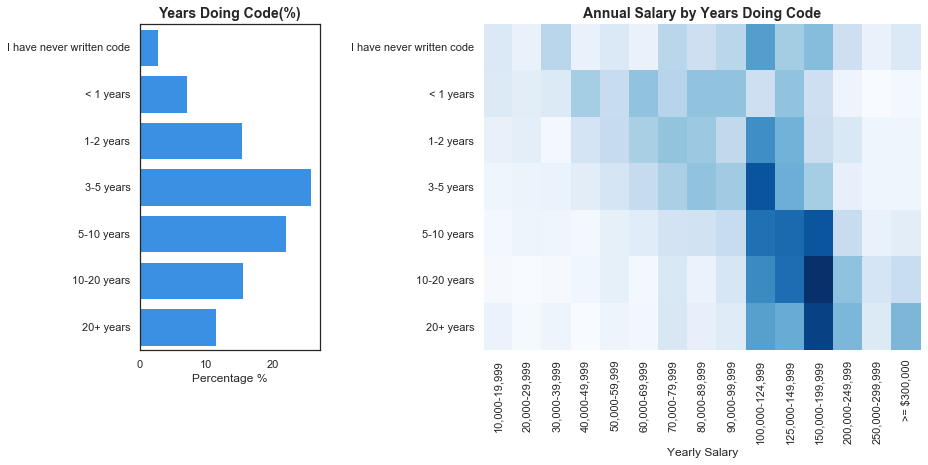

In [612]:
barplots_heatmap_single_answer('Q15', 'Years Doing Code(%)', 'Annual Salary by Years Doing Code',
                              order_rows = ['I have never written code','< 1 years', '1-2 years', '3-5 years', '5-10 years',
                                          '10-20 years', '20+ years'])

### 9. Favorite Media Sources (Q12) - Bar chart and salary heatmap side by side

                                                                 Q12_Part_1   pct
7     Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)  20.7
3                                  Kaggle (forums, blog, social media, etc)  17.1
8   Journal Publications (traditional publications, preprint journals, etc)  10.3
5                           YouTube (Cloud AI Adventures, Siraj Raval, etc)   9.8
2                            Reddit (r/machinelearning, r/datascience, etc)   8.6
0                                        Twitter (data science influencers)   7.8
6                Podcasts (Chai Time Data Science, Linear Digressions, etc)   6.9
4                                       Course Forums (forums.fast.ai, etc)   5.9
1                               Hacker News (https://news.ycombinator.com/)   4.9
9                              Slack Communities (ods.ai, kagglenoobs, etc)   4.4
11                                                                    Other   2.5
10              

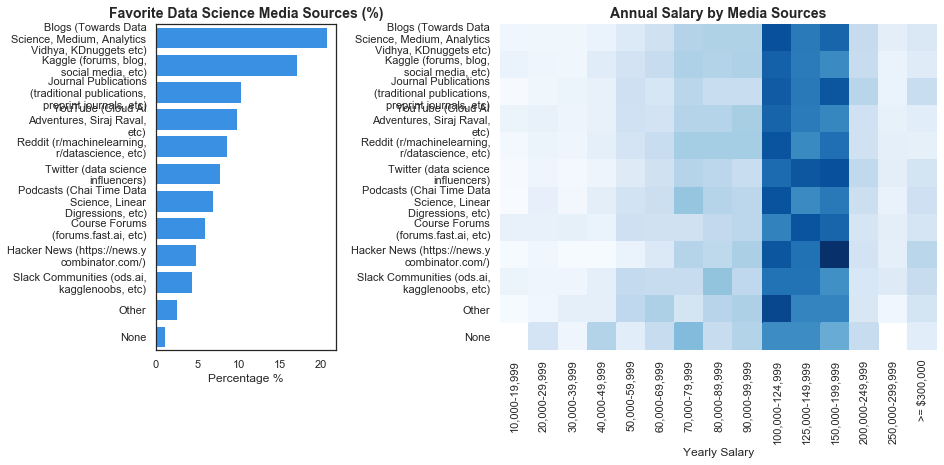

In [615]:
barplots_heatmap_multi_answer(['Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5', 'Q12_Part_6', 
                               'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10', 'Q12_Part_11', 'Q12_Part_12'], 
                              'Favorite Data Science Media Sources (%)', 
                              'Annual Salary by Media Sources', 
                              order_rows = False)

### 10. Try to model salary